<a href="https://colab.research.google.com/github/gabriele-pelliccioni/Task-Vectors-Fine-Tuning/blob/main/Fine-Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *\<Gabriele Pelliccioni\>*

**Matricola**: *\<1838084\>*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.utils import get_source_inputs
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout ,BatchNormalization
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile
import seaborn as sns
import librosa.display
import librosa
import pandas as pd
import numpy as np
import shutil
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

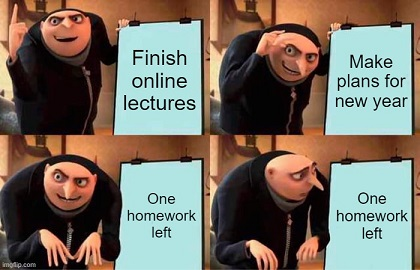

### Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**:
The dataset is taken from kaggle:  https://www.kaggle.com/datasets/chrisfilo/urbansound8k.  
It contains over 8000 wav files (less than 4 secs each) of urban sounds from 10 classes. The files are divided in 10 folders; in order to label them the dataset provides a csv file with the associations between wav file and label.  
The task chosen is audio classification.

In [ ]:
#at first we import the dataset from kaggle:
from google.colab import files     #loading personal kaggle token (important also for the weight in the next part.)
uploaded = files.upload()          #upload

Saving kaggle.json to kaggle.json


####Data Loading:

In [ ]:
#download urbansound 8k dataset: 5.61GB
!chmod 600 /content/kaggle.json
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.61G/5.61G [01:04<00:00, 141MB/s]
100% 5.61G/5.61G [01:04<00:00, 92.9MB/s]


In [ ]:
#extract the dataset:
with ZipFile('urbansound8k.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
#diving briefly in the metadata attached to the wav dataset:
dataset = pd.read_csv("UrbanSound8K.csv")
dataset = dataset[["slice_file_name","classID"]]
dataset[["classID"]].value_counts()
#it is interesting to see the balance of the classes:

classID
0          1000
2          1000
3          1000
4          1000
5          1000
7          1000
9          1000
8           929
1           429
6           374
dtype: int64

In [ ]:
#to proceed with preprocessing we define this function to merge each file of the dataset into one folder: (sorry for 3 for-loops but they were necessary)
def merge_folders(sources, destination):
    for source_folder in sources:                                               #iterating for each folder
        for root, _, files in os.walk(source_folder):                           #iterating through each file in the directory
            for file in files:                                                  #iterating for each file
                source_path = os.path.join(root, file)                          #creating path for the file
                destination_path = os.path.join(destination, file)              #creating path for the folder
                shutil.copy2(source_path, destination_path)                     #copy the file to the destination

In [ ]:
#here we apply the function to the folders:
os.makedirs("/content/train_folder", exist_ok=True)                             #creating folder if it doesn't exist
merge_folders(["fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold7", "fold8", "fold9"], "/content/train_folder") #merging folders

In [ ]:
#Now we create X and Y tensor for Train, Validation:

all_files = os.listdir("/content/train_folder")                                 #getting a list for each file (8732 wavs)

X_train, X_val = train_test_split(all_files, train_size=0.75, random_state=42)  #splitting files with 75% train and 25% validation
wav_to_class = dict(zip(dataset["slice_file_name"], dataset["classID"]))        #take in consideration the association between wav and corresponding label through the dataset csv.

Y_train = [wav_to_class[file_name] for file_name in X_train]                    #creating Y_train associating each .wav to his corresponding label
Y_val = [wav_to_class[file_name] for file_name in X_val]                        #creating Y_val, same way

#Now it's time for X and Y_test:
X_test = os.listdir("/content/fold10")                                          #obtaining X_test
Y_test = [wav_to_class[file_name] for file_name in X_test]                      #creating Y_test, same way

Here we compute log-mel spectrograms:  
Briefly, at first we compute a spectrogram by performing several fast-Fourier Transforms (FFT), then we convert it into mel-scale, a logarithmic transformation of the frequency, that allows the listener to perceive "pitches" of sound to be equal in distance from one another.  
At the end we convert the mel-spectrogram into logaritmic scale (log-mel-spectrogram); It is a sort of data normalization that enhance the low-intensity components in the spectrogram, helping to recognize certain phonetic characteristics of the sound.  
Now we are going to obtain LM spectrogram of shape (96,64,1) to match the shape of the input for the model.

In [ ]:
#Since we have .wav files in input we must convert extract the mel spectrogram of the audio and then compute the log-mel-spectrogram:
def wav_to_logmel(folder,filename):
    folder_path = os.path.join("/content/",folder)                              #create the path for train folder and then fold10
    wav_path = os.path.join(folder_path, filename)                              #create path for the audio in input
    audio, samp_rate = librosa.load(wav_path, sr=16000,mono=True)               #loading audio with librosa at mono 16kHz (as requested by the model)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=samp_rate, hop_length=int(samp_rate * 0.010), n_fft=int(samp_rate * 0.025), fmin=125, fmax=7500) #here we compute the mel spectrogram with features as mel n_fft as requested by the model
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)      #convert the mel spectrogram to the log scale

    #here we pad or truncate the audio to ensure its size is (64,96) ----> as requested by the model
    if log_mel_spectrogram.shape[1] < 96:
        pad_width = 96 - log_mel_spectrogram.shape[1]
        log_mel_spectrogram = np.pad(log_mel_spectrogram,
                                     pad_width=((0, 0), (0, pad_width)),
                                     mode='constant')

    if log_mel_spectrogram.shape[0] < 64:
        pad_width = 64 - log_mel_spectrogram.shape[0]
        log_mel_spectrogram = np.pad(log_mel_spectrogram,
                                     pad_width=((0, pad_width), (0, 0)),
                                     mode='constant')

    if log_mel_spectrogram.shape[1] > 96:
        log_mel_spectrogram = log_mel_spectrogram[:, :96]

    if log_mel_spectrogram.shape[0] > 64:
        log_mel_spectrogram = log_mel_spectrogram[:64, :]


    log_mel_spectrogram = log_mel_spectrogram.T                                 #transposing log-mel spectrogram
    log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram,axis=-1)           #adding dimension at the end
    return log_mel_spectrogram                                                  #log-mel spectrogram computed

In [ ]:
#converting each file to log-mel-spectrogram (around 5 min):
X_train = [wav_to_logmel("train_folder",filename) for filename in X_train]
X_val = [wav_to_logmel("train_folder",filename) for filename in X_val]
X_test = [wav_to_logmel("fold10",filename) for filename in X_test]

In [ ]:
#converting the ndarrays into tensors:
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)

Y_train = tf.convert_to_tensor(Y_train)
Y_val = tf.convert_to_tensor(Y_val)
Y_test = tf.convert_to_tensor(Y_test)

In [ ]:
#now we encode the labels with one hot encoding:
def one_hot_encode_labels(Y):

    class_labels = np.unique(Y.numpy())                                             #getting class labels (0-9)

    class_to_index = {class_label: i for i, class_label in enumerate(class_labels)} #mapping from class labels to indices

    indices = np.array([class_to_index[class_label] for class_label in Y.numpy()])  #converting class labels to indices

    one_hot_encoded = tf.one_hot(indices, depth=len(class_labels))                  #one hot encoding of the indices

    return tf.convert_to_tensor(one_hot_encoded, dtype=tf.float32)                  #back to tensors


#one hot encoding by function of train, validation and test:
Y_train = one_hot_encode_labels(Y_train)
Y_val = one_hot_encode_labels(Y_val)
Y_test = one_hot_encode_labels(Y_test)

print(Y_train)  #example

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(5921, 10), dtype=float32)


#### Data Example:

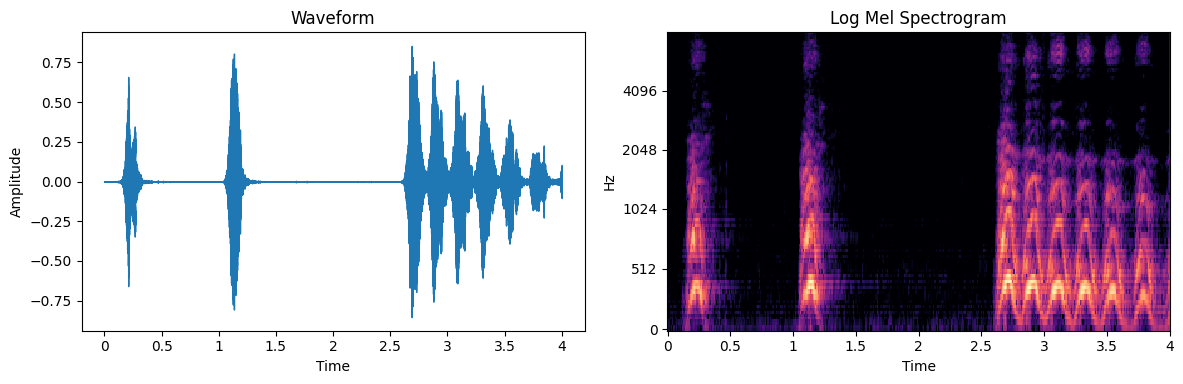

In [ ]:
#here we plot the audio and the log mel spectrogram with a button to listen the audio:

audio, sr = librosa.load("/content/fold1/101415-3-0-2.wav", sr=16000, mono=True) #taking an example
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=int(sr * 0.010), n_fft=int(sr * 0.025), fmin=125, fmax=7500)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)


#plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.set_theme(style='darkgrid')

#plot the audio:

librosa.display.waveshow(audio, sr=sr, ax=ax1)
ax1.set_title('Waveform')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=int(sr * 0.010), x_axis='time', y_axis='mel', ax=ax2)
ax2.set_title('Log Mel Spectrogram')

#hear the audio:
play_button = Audio(audio, rate=sr)
display(play_button)

#plot show
plt.tight_layout()
plt.show()


### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: Here i'm going to implement task vectors method, in particular learning via addition and forgetting via negation methods.  
The model is a pre-trained manageable with tf.keras: https://github.com/DTaoo/VGGish/blob/master/vggish.py; it was trained on 500 sounds of  "audioset" and gives in output 128 dimensional embeddings of each AudioSet segment produced from a VGG-like audio classification model.  
I decided to fine-tune the model with additional layers and task vectors in order to classify log-mel spectrograms of the first dataset into 10 classes; before that, i am going to fine-tuned the model on urban-sound dataset, creating a models that i will use to calculate task vector w.r.t. the pretrained one.  
Summarizing, the model is trained on hundreds of sound types, now we are going to adapt it to a more specific task.    

#### Pre-Trained Model:

In [ ]:
#downloading the weights for the (pretrained) model:
!kaggle datasets download -d gabrielepelliccioni/vggish-audioset-weights        #kaggle token uploaded on loading data above

 31% 5.00M/16.1M [00:00<00:00, 38.6MB/s]
100% 16.1M/16.1M [00:00<00:00, 75.2MB/s]


In [ ]:
#unzip
with ZipFile('vggish-audioset-weights.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
def VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=True, pooling='avg'):

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = 128

    # input shape
    if input_shape is None:
        input_shape = (96, 64, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)


    if include_top:
        # FC block
        x = Flatten(name='flatten_')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_1')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_2')(x)
        x = Dense(out_dim, activation='relu', name='vggish_fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = aud_input
    # Create model.
    model = Model(inputs, x, name='VGGish')

    # load weights
    if load_weights:
        if weights == 'audioset':
            if include_top:
                model.load_weights("/content/drive/MyDrive/vggish_audioset_weights.h5")
            else:
                model.load_weights("vggish_audioset_weights_without_fc2.h5")
        else:
            print("failed to load weights")

    return model

#### Task Vectors:
I decided to implement this method because it was specifically designed to improve the task of a pre-trained model.  
Task vectors represent the direction in weight space that improves performance of each individual task.
The calculation of a tv is a simple subtraction between pretrained and fine-tuned weights.   
The method presupposes the addition (or subtraction) of task vectors of other models with the same architecture as the initial pre-trained one. Given the difficulty in finding suitable models, the procedure was carried out on the same model.   
At first, to calculate each tasks vector we fine-tune the model:


##### Setting Up fine-tuned model (urban-sound dataset):   
This time to fine-tune it would not have made sense to freeze pre-trained layers, as we need them to update in order to obtain a subtraction on the task vectors that does not lead to a zero weight vector.  
So in order to fine-tune I added dense layers to classify and lowered the learning rate to 10^4 in order to avoid divergence.


In [ ]:
#defining fine-tuned model 1:
model_1 = VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=False, pooling='avg')

#then we add a flatten layer followed by 4 dense and some regularization(Batch Normalization and Dropout)
x = Flatten(name='flatten_new2')(model_1.output)                                #flatten
x = Dense(256, activation='relu', name='Dense')(x)                              #Dense
x = Dropout(0.1, name='dropout')(x)                                             #Dropout
x = Dense(128, activation='relu', name='Dense2')(x)                             #Dense
x = Dropout(0.1, name='dropout2')(x)                                            #Dropout
predictions = Dense(10,activation="softmax",name="final")(x)                    #final dense to predict 10 classes

predictions = Dense(10, activation='softmax', name='output')(x)                 #dense to predict 10 classes

fine_tuned_model = Model(inputs=model_1.input, outputs=predictions)             #defining the model

#we define also here the early stopping valid for all the models below
early_stopping = EarlyStopping(monitor='val_loss',
                               mode="min",verbose=1,
                               patience=5)

In [ ]:
#train ftm:
fine_tuned_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001))
history = fine_tuned_model.fit(X_train, Y_train,
                                epochs=25,
                                batch_size=64,
                                validation_data=(X_val, Y_val),callbacks=[early_stopping])

Epoch 1/25
93/93 [==============================] - 9s 55ms/step - loss: 2.0846 - accuracy: 0.2138 - val_loss: 1.7799 - val_accuracy: 0.3967
Epoch 2/25
93/93 [==============================] - 5s 52ms/step - loss: 1.6358 - accuracy: 0.4224 - val_loss: 1.3902 - val_accuracy: 0.5208
Epoch 3/25
93/93 [==============================] - 5s 56ms/step - loss: 1.3550 - accuracy: 0.5296 - val_loss: 1.1937 - val_accuracy: 0.5780
Epoch 4/25
93/93 [==============================] - 5s 55ms/step - loss: 1.2102 - accuracy: 0.5835 - val_loss: 1.1139 - val_accuracy: 0.6251
Epoch 5/25
93/93 [==============================] - 5s 51ms/step - loss: 1.0978 - accuracy: 0.6195 - val_loss: 1.0659 - val_accuracy: 0.6216
Epoch 6/25
93/93 [==============================] - 5s 55ms/step - loss: 0.9959 - accuracy: 0.6599 - val_loss: 0.9881 - val_accuracy: 0.6570
Epoch 7/25
93/93 [==============================] - 5s 58ms/step - loss: 0.9110 - accuracy: 0.6919 - val_loss: 0.9125 - val_accuracy: 0.6839
Epoch 8/25
93

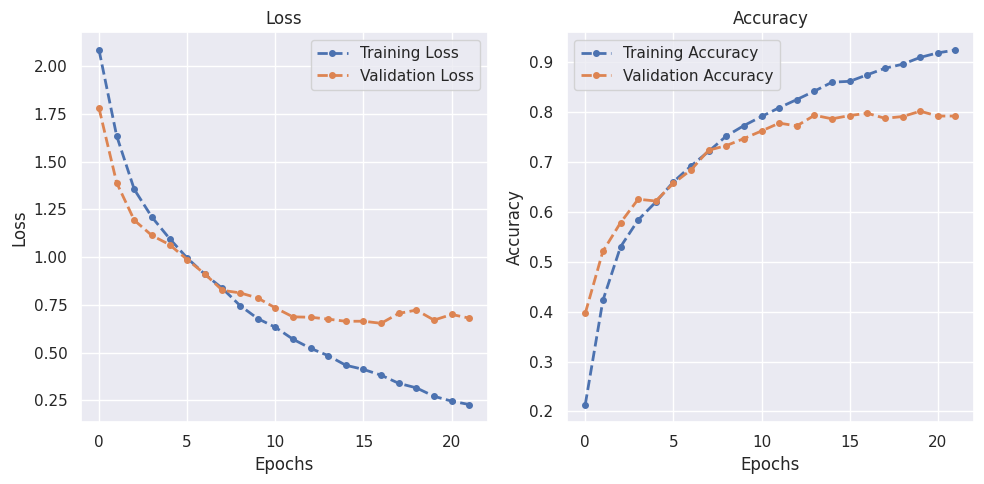

In [ ]:
###Plotting loss and accuracy of fine-tuned model:

plt.figure(figsize=(10, 5))
sns.set_theme(style='darkgrid')

#Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss',linestyle="--", linewidth=2,marker="o",  markersize=4)
plt.plot(history.history['val_loss'], label='Validation Loss',linestyle="--", linewidth=2, marker='o', markersize=4)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy',linestyle="--", linewidth=2,marker="o",  markersize=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',linestyle="--", linewidth=2, marker='o', markersize=4)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test = fine_tuned_model.evaluate(X_test,Y_test,verbose=0)
print("FINE-TUNED MODEL --> TEST Accuracy:",f"{test[1]*100:.1f}%")

FINE-TUNED MODEL --> TEST Accuracy: 62.0%


The result is not very high, this is due to the fact that all the pretrained layers are used, by freeing some, especially the first 4 (empirically) it is possible to obtain accuracy around 85-90%.

##### Calculating task vectors:

In [ ]:
#at first we define our pre-trained model:
model = VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=False, pooling='avg')

In [ ]:
#Now we calculate task vectors of fine-tuned model w.r.t. pre-trained model
pretrained_weights = model.get_weights()                                        #taking weights of the pretrained model
weights = fine_tuned_model.get_weights()                                        #taking weights of fine-tuned model

#calculating task vector by subtracting weights for the first 12 weights (all fo the pretrained weights to match the shapes)
task_vector = np.array([ft - pt for pt, ft in zip(pretrained_weights[:12], weights[:12])],dtype=object)

#####Learning via Addition

In [ ]:
#calculating learning via addition
learning_via_addition = pretrained_weights + task_vector                        #adding task vector obtaining FINE-TUNED MODEL VIA ADDITION

model.set_weights(learning_via_addition)                                        #setting updated via addition weights

#then we can fine-tune our model with added weights:

x = Flatten(name='flatten_new2')(model.output)                                  #flatten
x = Dense(256, activation='relu', name='Dense')(x)                              #Dense
x = Dropout(0.1, name='dropout')(x)                                             #Dropout
x = Dense(128, activation='relu', name='Dense2')(x)                             #Dense
x = Dropout(0.1, name='dropout2')(x)                                            #Dropout

predictions = Dense(10,activation="softmax",name="final")(x)                    #final dense to predict 10 classes

addition_model = Model(inputs=model.input, outputs=predictions)                 #model defined

#compiling:
addition_model.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))

Addition Model Test:

In [ ]:
addition_test_1 = addition_model.evaluate(X_test,Y_test,verbose=0)
print("Addition Test 1 Accuracy:",f"{addition_test_1[1]*100:.1f}%")             #low accuracy(see comments below)

Addition Test 1 Accuracy: 15.9%


The last layers are not trained, only the pre-trained ones, therefore the test is not performing. Consequently, it is advisable to retrain the network.

Here we continue with training:

In [ ]:
#fine tuning on the updated model
history = addition_model.fit(X_train, Y_train,
                                       epochs=25,
                                       batch_size=64,
                                       validation_data=(X_val, Y_val))

Epoch 1/25
93/93 [==============================] - 9s 54ms/step - loss: 1.8234 - accuracy: 0.3856 - val_loss: 1.1463 - val_accuracy: 0.6226
Epoch 2/25
93/93 [==============================] - 5s 52ms/step - loss: 1.0929 - accuracy: 0.6333 - val_loss: 0.8857 - val_accuracy: 0.7123
Epoch 3/25
93/93 [==============================] - 5s 59ms/step - loss: 0.8344 - accuracy: 0.7242 - val_loss: 0.8363 - val_accuracy: 0.7259
Epoch 4/25
93/93 [==============================] - 5s 54ms/step - loss: 0.6911 - accuracy: 0.7727 - val_loss: 0.6837 - val_accuracy: 0.7812
Epoch 5/25
93/93 [==============================] - 5s 52ms/step - loss: 0.5942 - accuracy: 0.8032 - val_loss: 0.6963 - val_accuracy: 0.7746
Epoch 6/25
93/93 [==============================] - 5s 54ms/step - loss: 0.5173 - accuracy: 0.8301 - val_loss: 0.6445 - val_accuracy: 0.7908
Epoch 7/25
93/93 [==============================] - 6s 63ms/step - loss: 0.4768 - accuracy: 0.8390 - val_loss: 0.6609 - val_accuracy: 0.7974
Epoch 8/25
93

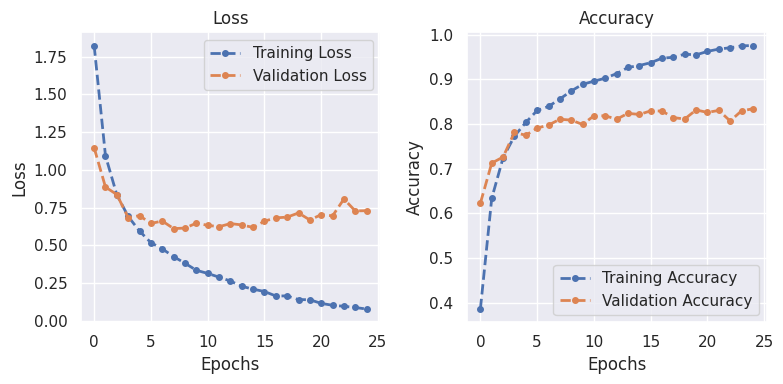

In [ ]:
plt.figure(figsize=(8, 4))
sns.set_theme(style='darkgrid')

#Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss',linestyle="--", linewidth=2,marker="o",  markersize=4)
plt.plot(history.history['val_loss'], label='Validation Loss',linestyle="--", linewidth=2, marker='o', markersize=4)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy',linestyle="--", linewidth=2,marker="o",  markersize=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',linestyle="--", linewidth=2, marker='o', markersize=4)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
addition_test_2 = addition_model.evaluate(X_test,Y_test,verbose=0)
print("Addition TEST 2 Accuracy:",f"{addition_test_2[1]*100:.1f}%")

Addition TEST 2 Accuracy: 68.2%


"Learning with addition" brings the test accuracy, in mean, from 65% to around 70%. The model was pre-trained on high-level features, so achieving this result is acceptable.  
After setting the new weights, the model needed more training to achieve acceptable results, because a single addition of task vector is not enough for this task (and in general).
The additioned model starts with val_accuracy, during training, at 60%, underlying the fact that it is initialized with fine-tuned weights.  
Summarizing, addition of task vector can be useful, especially through multiple well-trained model on specific audio classification tasks, bringing more robust results without further training.

It is important to say that to achieve better results, the fine-tuned architecture could be improved and, at the same time, it can be found a larger dataset to train better the model.  

#####Forgetting via Negation:

In [ ]:
#resetting weights of pre-trained model:
model = VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=False, pooling='avg')

In [ ]:
forgetting_via_negation = model.get_weights() - task_vector                     #subtracting task vector

model.set_weights(forgetting_via_negation)                                      #setting updated via deletion weights

#then we can fine-tune our model with subtracted weights:

x = Flatten(name='flatten_new2')(model.output)                                  #flatten
x = Dense(256, activation='relu', name='Dense')(x)                              #Dense
x = Dropout(0.1, name='dropout')(x)                                             #Dropout
x = Dense(128, activation='relu', name='Dense2')(x)                             #Dense
x = Dropout(0.1, name='dropout2')(x)                                            #Dropout

predictions = Dense(10,activation="softmax",name="final")(x)                    #final dense to predict 10 classes

subtracted_model = Model(inputs=model.input, outputs=predictions)               #model defined

#compiling:
subtracted_model.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))

Subtracted model test:

In [ ]:
subtraction_test_1 = subtracted_model.evaluate(X_test,Y_test,verbose=0)
print("Subtraction Test 1 Accuracy:",f"{subtraction_test_1[1]*100:.1f}%")       #low accuracy(see comments below)

Subtraction Test 1 Accuracy: 3.8%


  As learning via addition, here the accuracy is really low because last layers are not trained; at the same time the subtraction of the task vector redirect the weights in the direction opposite to the task. It is interesting to re-train the network on the task if effectively the initializazion is worse with the subtraction of the task vector.

In [ ]:
#fine tuning on the updated model
history = subtracted_model.fit(X_train, Y_train,
                                       epochs=25,
                                       batch_size=64,
                                       validation_data=(X_val, Y_val),
                                       callbacks=[early_stopping])

Epoch 1/25
93/93 [==============================] - 7s 51ms/step - loss: 2.1599 - accuracy: 0.2032 - val_loss: 1.9276 - val_accuracy: 0.3257
Epoch 2/25
93/93 [==============================] - 5s 52ms/step - loss: 1.7977 - accuracy: 0.3542 - val_loss: 1.5774 - val_accuracy: 0.4438
Epoch 3/25
93/93 [==============================] - 5s 59ms/step - loss: 1.5629 - accuracy: 0.4440 - val_loss: 1.3685 - val_accuracy: 0.5172
Epoch 4/25
93/93 [==============================] - 5s 56ms/step - loss: 1.4014 - accuracy: 0.5161 - val_loss: 1.2262 - val_accuracy: 0.5709
Epoch 5/25
93/93 [==============================] - 5s 55ms/step - loss: 1.3160 - accuracy: 0.5442 - val_loss: 1.1859 - val_accuracy: 0.5861
Epoch 6/25
93/93 [==============================] - 5s 57ms/step - loss: 1.2251 - accuracy: 0.5795 - val_loss: 1.1090 - val_accuracy: 0.6160
Epoch 7/25
93/93 [==============================] - 6s 66ms/step - loss: 1.1588 - accuracy: 0.6072 - val_loss: 1.0947 - val_accuracy: 0.6130
Epoch 8/25
93

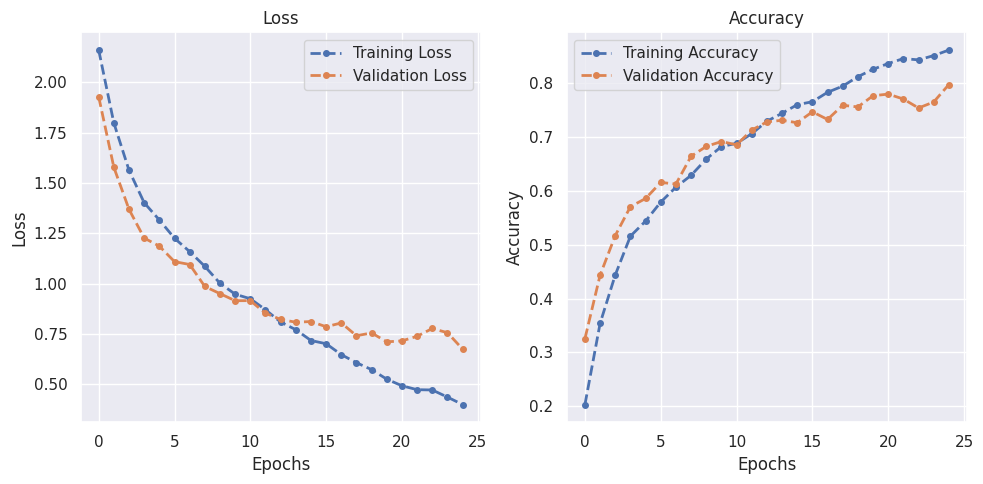

In [ ]:
plt.figure(figsize=(10, 5))
sns.set_theme(style='darkgrid')

#Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss',linestyle="--", linewidth=2,marker="o",  markersize=4)
plt.plot(history.history['val_loss'], label='Validation Loss',linestyle="--", linewidth=2, marker='o', markersize=4)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy',linestyle="--", linewidth=2,marker="o",  markersize=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',linestyle="--", linewidth=2, marker='o', markersize=4)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
subtraction_test_2 = subtracted_model.evaluate(X_test,Y_test,verbose=0)
print("Subtraction Test 2 Accuracy:",f"{subtraction_test_2[1]*100:.1f}%")

Subtraction Test 2 Accuracy: 61.6%


 "Forgetting via Negation" has worse performance.  
 The training was done only to show that the model initialization is more imprecise, given that the val accuracy starts from 25%.  
 In this context, the layers after the model plays the most important role; the subtraction of the weights helps to "forgetting" the task, but in the end the fine-tuned model is specially built to classify this dataset, in fact it gradually improves results during training.  
 It is important to underline the fact that further training was not necessary, because in generale task vectors allow you to learn or forget without the need for further training.
 As mentioned previously, through more data and training epochs, the results can be more robust.

### Exercise 2: Interpreting the results (5 points)



**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

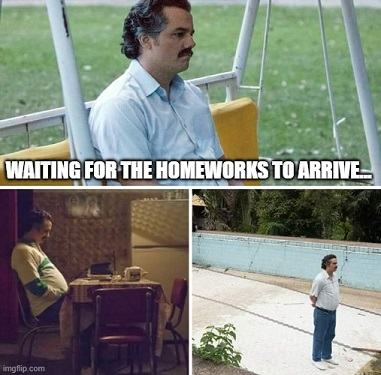